In [1]:
import networkx as nx
import pandas
from hatchet import *
import os
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import igraph
import platform
from graph_tool.all import *

/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)
/usr/local/lib/python3.6/dist-packages/seaborn/apionly.py:9: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [2]:
from actions.groupBy import groupBy
from state import State
from callgraph import CallGraph
from preprocess import PreProcess

In [3]:
%matplotlib inline

In [4]:
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:,.2f}'.format
plt.rcParams['figure.figsize'] = (16, 12)

In [5]:
# Linux path
if platform.system() == "Linux":
    callflow_path = "/home/vidi/Work/llnl/CallFlow/"
else:
    #Mac OSx path
    callflow_path = "/Users/jarus/ucd/Research/Visualisation/projects/CallFlow"

dataset_path = ["data/lulesh-1/db-ampi4-100-1", "data/lulesh-1/db-ampi4-100-8"]
dataset = ['db-ampi4-100-1', 'db-ampi4-100-8']    

In [6]:
# Create Graphframes.
def create_gfs(file_format, paths):    
        print("Creating graphframes....")                                                                                             
        ret = []                                                                                                                         
        for idx, path in enumerate(paths):
            path = os.path.abspath(os.path.join(callflow_path, path)) 
            gf = GraphFrame()   
            gf.from_hpctoolkit(path, 3)                                                                            
            ret.append(gf) 
            print(str(idx) + ":" + path)                                                                                              
            print("[Create] Rows in dataframe: {0}".format(gf.dataframe.shape[0]))                       
        return ret 

gfs = create_gfs('hpctoolkit', dataset_path)

Creating graphframes....
0:/home/vidi/Work/llnl/CallFlow/data/lulesh-1/db-ampi4-100-1
[Create] Rows in dataframe: 185290
1:/home/vidi/Work/llnl/CallFlow/data/lulesh-1/db-ampi4-100-8
[Create] Rows in dataframe: 300890


In [7]:
# util functions

def lookup(df, node):                                                                                                                    
    return df.loc[df['node'] == node] 

def lookup_with_name(df, name):
    return df.loc[df['name'] == name]

def getMaxIncTime(gf):                                                                                                                   
    ret = 0.0                                                                                                                            
    for root in gf.graph.roots:                                                                                                          
        ret = max(ret, lookup(gf.dataframe, root)['CPUTIME (usec) (I)'].max())                                                           
    return ret                                                                                                                           
                                                                                                                                         
def getMaxExcTime(gf):                                                                                                                   
    ret  = gf.dataframe['CPUTIME (usec) (E)'].max()                                                                                      
    return ret                                                                                                                           
               
def special_lookup(gf, df_index):   
    return gf.dataframe.loc[gf.dataframe['name'] == df_index] 

In [8]:
# Filter graphframe and graph
def filter_gfs(gfs, filterBy):                                                                                                   
    # Create the graph frames from the paths and corresponding format using hatchet                                                  
    fgfs = []                                                                                                                        
    # Filter graphframes based on threshold                                                                                          
    for idx, gf in enumerate(gfs):                                                                                              
        print("Filtering the dataframe!")                                                                                         
        if filterBy == "IncTime":                                                                                          
            max_inclusive_time = getMaxIncTime(gf)                                                                             
            filter_gf = gf.filter(lambda x: True if(x['CPUTIME (usec) (I)'] > 0.01*max_inclusive_time) else False)                   
        elif self.args.filterBy == "ExcTime":                                                                                        
            max_exclusive_time = getMaxExcTime(gf)                                                                             
            print('[Filter] By Exclusive time = {0})'.format(max_exclusive_time))                                                 
            filter_gf = gf.filter(lambda x: True if (x['CPUTIME (usec) (E)'] > 0.01*max_exclusive_time) else False)                  
        else:                                                                                                                        
            print("Not filtering.... Can take forever. Thou were warned")                                                         
            filter_gf = gf                                                                                                           
        print('[Filter] Removed {0} rows.)'.format(gf.dataframe.shape[0] - filter_gf.dataframe.shape[0]))                                                                                                                            
        print("Grafting the graph!")                                                                                            
        filter_gf = filter_gf.graft()                                                                                                
        print("[Graft] {0} rows left".format(filter_gf.dataframe.shape[0]))                           
        fgfs.append(filter_gf)                                                                                                       
    return fgfs      

# filtered graph frames.
fgfs = filter_gfs(gfs, 'IncTime')    

Filtering the dataframe!
(185290, 10)
[Filter] Removed 184465 rows.)
Grafting the graph!
[Graft] 825 rows left
Filtering the dataframe!
(300890, 10)
[Filter] Removed 300045 rows.)
Grafting the graph!
[Graft] 845 rows left


In [9]:
# Print filtered graph information. 
for idx, fgf in enumerate(fgfs):
    print("Shape of the dataframe from graph ({0}): {1}".format(dataset[idx], fgf.dataframe.shape))

Shape of the dataframe from graph (db-ampi4-100-1): (825, 10)
Shape of the dataframe from graph (db-ampi4-100-8): (845, 10)


In [10]:
# add n_index to the dataframe.
def add_n_index(gf):
    gf.dataframe['n_index'] = gf.dataframe.groupby('nid').ngroup()

In [11]:
# ret = {
#   node_name : df_index
#}
def df_index_name_mapper(graph, df):
    ret = {}
    node_count = 0
    root = graph.roots[0]
    node_gen = graph.roots[0].traverse()
    try:
        while root.callpath != None:
            node_count += 1
            root = next(node_gen)
            ret[root.callpath[-1]] = root.df_index
    except StopIteration:
        pass
    finally:
        print("Total nodes in graph: ", node_count)
        del root
    return ret

# add df_index to the dataframe
def add_df_index(gf):
    df_index_name_map = df_index_name_mapper(gf.graph, gf.dataframe)
    gf.dataframe['df_index'] = gf.dataframe['name'].apply(lambda node: df_index_name_map[node] if node in df_index_name_map else 'as ')   

In [12]:
# add callee and caller data into the dataframe
def add_callers_and_callee(graph, df):
    callees = {}
    callers = {}
    root = graph.roots[0]
    node_gen = graph.roots[0].traverse()
    root_df = root.callpath[-1]
    callers[root_df] = []
    callees[root_df] = []
    try:                                                                                                                        
        while root.callpath != None:                                                                                            
            root = next(node_gen)                                                                                               
            if root.parent:                                                                                                     
                root_df = root.callpath[-1]                                                                                     
                parent_df = root.parent.callpath[-1]                                                                            
                if parent_df not in callees:                                                                                    
                    callees[parent_df] = []              
                callees[parent_df].append(root_df)                                                                              
                                                                                                                                        
                if root_df not in callers:                                                                                      
                    callers[root_df] = []                                                                                       
                callers[root_df].append(parent_df)                                                                              
                                                                                                                                        
    except StopIteration:                                                                                                       
        pass                                                                                                                    
    finally:                                                                                                                    
        del root                                                                                                                
                                                                                                                                        
    df['callees'] = df['name'].apply(lambda node: callees[node] if node in callees else [])                           
    df['callers'] = df['name'].apply(lambda node: callers[node] if node in callers else []) 

In [13]:
#pre-process dataframe to add more information. 
def preprocess(state):
    preprocess = PreProcess.Builder(state).add_df_index().add_n_index().add_mod_index().add_path().add_callers_and_callees().add_show_node().add_vis_node_name().update_module_name().clean_lib_monitor().add_max_incTime().add_incTime().add_excTime().add_avg_incTime().add_imbalance_perc().build() 

In [14]:
#NetworkX stuff.
def create_nx_graph(state):
    g = nx.DiGraph()
    return g

In [15]:
def main(fgfs):
    states = []
    for idx, fgf in enumerate(fgfs):
        state = State(fgf)
        preprocess(state)
        groupBy(state, 'module')
        create_nx_graph(state)

In [16]:
main(fgfs)

Total nodes in the graph 114
__correctly_grouped_prefixwc 1
CthStartThread 1
_INTERNAL_8_tcharm_C_22509075::startTCharmThread(TCharmInitMsg*) 2
AMPI_threadstart 3
MPI_threadstart_t::start() 4
AMPI_Fallback_Main 5
AMPI_Main_cpp(int, char**) 6
Loop@lulesh.cc:2790 1
_INTERNAL_9_lulesh_cc_07ac9422::LagrangeLeapFrog(Domain&) 7
_INTERNAL_9_lulesh_cc_07ac9422::LagrangeNodal(Domain&) 8
_INTERNAL_9_lulesh_cc_07ac9422::CalcForceForNodes(Domain&) 9
_INTERNAL_9_lulesh_cc_07ac9422::CalcVolumeForceForElems(Domain&) 10
_INTERNAL_9_lulesh_cc_07ac9422::IntegrateStressForElems(Domain&, double*, double*, double*, double*, int, int) 11
Loop@lulesh.cc:550 2
_INTERNAL_9_lulesh_cc_07ac9422::CalcElemShapeFunctionDerivatives(double const*, double const*, double const*, double (*) [8], double*) 12
_INTERNAL_9_lulesh_cc_07ac9422::CalcElemNodeNormals(double*, double*, double*, double const*, double const*, double const*) 13
_INTERNAL_9_lulesh_cc_07ac9422::CalcHourglassControlForElems(Domain&, double*, double) 14


void Release<double>(double**) 25
_int_free 12
systrim.isra.3 13
__GI___default_morecore 14
__GI___sbrk 15
__brk 16
Stmt11058@<unknown file>:0 17
CommSyncPosVel(Domain&) 26
Loop@lulesh-comm.cc:1403 18
Loop@lulesh-comm.cc:1405 19
Loop@lulesh-comm.cc:1406 20
_INTERNAL_9_lulesh_cc_07ac9422::LagrangeElements(Domain&, int) 27
_INTERNAL_9_lulesh_cc_07ac9422::CalcLagrangeElements(Domain&, double*) 28
CalcKinematicsForElems(Domain&, double*, double, int) 29
Loop@lulesh.cc:1539 21
CalcElemVolume(double const*, double const*, double const*) 30
_INTERNAL_9_lulesh_cc_07ac9422::CalcElemVolume(double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double) 31
_INTERNAL_9_lulesh_cc_07ac9422::CalcElemCharacteristicLength(double const*, double const*, double const*, double) 32
_INTERNAL_9_lulesh_cc_07ac9422::CalcElemShapeFunctionDerivatives(double const*, double const*, double

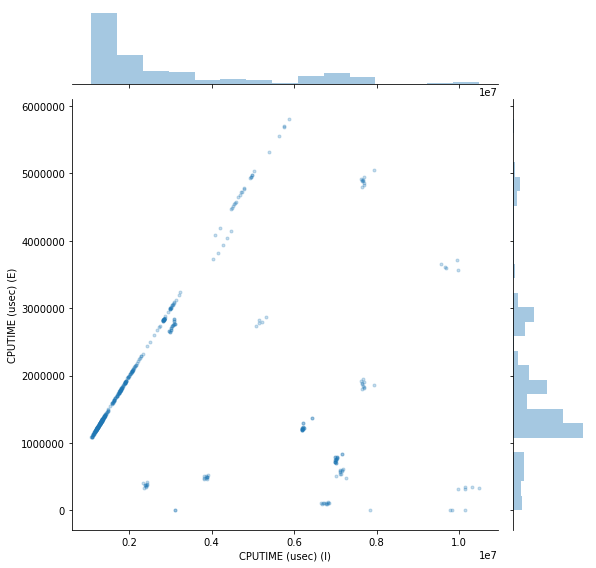

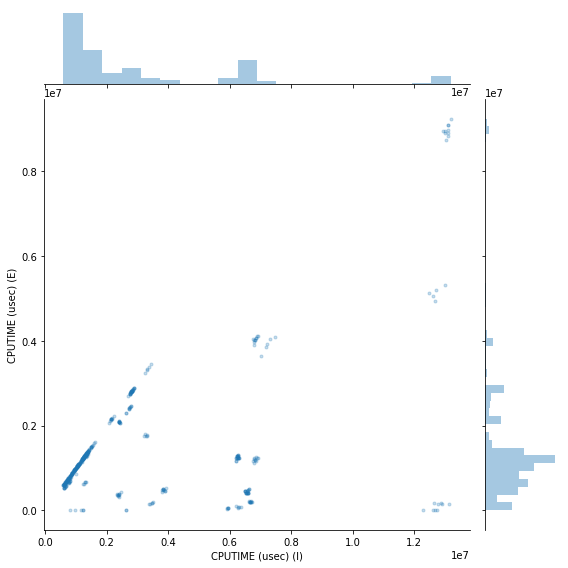

In [17]:
# Joint plot of the Inclusive and Exclusive times.
df = fgfs[0].dataframe
df2 = fgfs[1].dataframe
root_max_df = 107348942.00
root_max_df2 = 145114370.00
sns.jointplot('CPUTIME (usec) (I)', 'CPUTIME (usec) (E)',
              df.loc[(df['CPUTIME (usec) (I)'] < 0.10*107348942.00) &
                     (df['CPUTIME (usec) (E)'] > 0)],
              alpha=.25, marker='.', height=8);
sns.jointplot('CPUTIME (usec) (I)', 'CPUTIME (usec) (E)',
              df2.loc[(df2['CPUTIME (usec) (I)'] < 0.10*145114370.00) &
                     (df2['CPUTIME (usec) (E)'] > 0)],
              alpha=.25, marker='.', height=8);

In [18]:
state_gf1.graph = fgfs[0].graph
state_gf1.df = fgfs[0].dataframe

state_gf2.graph = fgfs[1].graph
state_gf2.df = fgfs[1].dataframe
groupBy(fgfs[0], 'path')

NameError: name 'state_gf1' is not defined

In [ ]:
g1 = nx.DiGraph()
g2 = nx.DiGraph()

def add_paths(g, df, path_name):
    for idx, row in df.iterrows():
        print(row)
        g.add_path(row[path_name])

add_paths(g1, df, 'path')
add_paths(g2, df, 'path')